In [482]:
from env import *
from env_tradestation import *
from data_retriever_simple import Client
import acquire
import prepare

import cbpro
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE, SelectKBest

import warnings
warnings.filterwarnings("ignore")

np.random.seed(123)

Basis for much of this: https://jfin-swufe.springeropen.com/track/pdf/10.1186/s40854-020-00217-x.pdf

# Personal Project - Compare the ability to predict cryptocurrency closing prices using machine learning and ARIMA models

## Start with acquiring crypto data
- Will acquire Bitcoin, Ethereum, and Litecoin data as these have some of the longest price histories and greatest liquidity

In [2]:
desired_products = ['BTC-USD',
 'ETH-USD',
 'LTC-USD']

In [3]:
results = acquire.get_data_from_csv()

In [4]:
prepared_results = prepare.prepare_crypto_data(results)

Max first date is 2016-08-17 00:00:00, starting all dataframes at this day
Corrected btc low data for 2017-04-15


### First iteration only using BTC

In [5]:
btc=prepared_results['BTC_USD']

In [6]:
btc.isna().sum()

time      0
low       0
high      0
open      0
close     0
volume    0
dtype: int64

No nulls

In [7]:
btc.describe()

,low,high,open,close,volume
count,2075.000000,2075.000000,2075.000000,2075.000000,2075.000000
mean,15367.271296,16353.665287,15891.738578,15910.606708,14627.887462
std,16901.301024,17955.831798,17468.665539,17473.333789,11638.656327
min,568.120000,573.310000,570.830000,570.840000,683.798071
25%,4082.865000,4365.630000,4249.675000,4258.360000,7144.589967
50%,8215.660000,8760.430000,8522.300000,8525.070000,11718.880202
75%,17445.630000,18601.875000,17830.325000,17940.440000,18296.256136
max,66261.790000,69000.000000,67554.130000,67554.840000,130316.646844


Min btc value of 0.06 is suspicious and should be corrected

In [8]:
# Incorporated into prepare
# btc.index[btc.low == 0.06]

# Gather minute data from that day to fix the low value
# minute_data = acquire.acquire_crypto_data(acquire.get_full_product_info(['BTC-USD']),datetime(2017, 4, 15, 0,0,0), datetime(2017, 4, 15, 23, 59, 0), 60)

# minute_data['BTC-USD']=minute_data['BTC-USD'].loc[(minute_data['BTC-USD'].index<'2017-04-15 23:00:00' )|(minute_data['BTC-USD'].index>'2017-04-15 23:50:00')]

# minute_data['BTC-USD'].low.min()

# btc.loc['2017-04-15','low'] = minute_data['BTC-USD'].low.min()

In [9]:
# auth_client = cbpro.AuthenticatedClient(api_key, secret_key, passphrase)

In [10]:
# desired_products_with_info = acquire.get_full_product_info(desired_products)

In [11]:
# results = acquire.acquire_crypto_data(desired_products_with_info, datetime.now()-timedelta(days=3000), datetime.now(), minute_bars=86400)

Text(0.5, 1.0, 'Bitcoin data starts earliest')

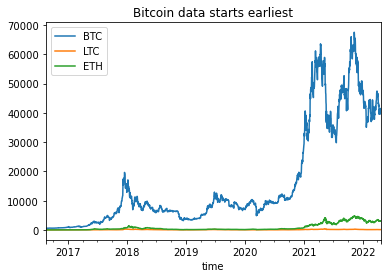

In [12]:
results['BTC_USD'].close.plot(label='BTC')
results['LTC_USD'].close.plot(label='LTC')
results['ETH_USD'].close.plot(label='ETH')
plt.legend()
plt.title('Bitcoin data starts earliest')

In [13]:
print('Min data bitcoin: ',results['BTC_USD'].index.min())
print('Min data litecoin: ',results['LTC_USD'].index.min())
print('Min data ethereum: ',results['ETH_USD'].index.min())

Min data bitcoin:  2016-08-17 00:00:00
Min data litecoin:  2016-08-17 00:00:00
Min data ethereum:  2016-08-17 00:00:00


Will truncate data so all starts at same day

### Volatility:
- relative price range: RR
- range volatility estimator of Parkinson: sigma  - lags 1-7

#### Lagged log returns, 1-7 days earlier

In [14]:
btc = prepare.add_features(btc)

## Add target and features (all added to prepare.py file)

In [15]:
# # forward 1 day log returns
# btc["log_ret_fwd"] = np.log(btc.close) - np.log(btc.close.shift(-1))
# # forward standard returns
# btc["ret_fwd"] = btc.close.shift(-1) - btc.close
# btc["pct_chg"] = btc.close.pct_change()

In [16]:
# for i in range(1,8):
#     btc[f'log_ret_lag_{i}'] = np.log(df.close) - np.log(df.close.shift(i))

## Split data

In [17]:
train_size = int(len(btc) * .5)
validate_size = int(len(btc) * .3)
test_size = int(len(btc) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = btc[: train_size]
validate = btc[train_size : validate_end_index]
test = btc[validate_end_index : ]

### Get summary statistics for each dataset

In [18]:
summary_df = pd.DataFrame()
def get_summary_statistics(df, target, index_name):
    return pd.concat([summary_df,pd.DataFrame(data={'mean':df[target].mean()*100,
                              'median':df[target].median()*100,
                              'min':df[target].min()*100,
                              'max':df[target].max()*100,
                              'std':df[target].std()*100,
                              'iqr':stats.iqr(df[target]),
                              'skewness':stats.skew(df[target]),
                              'excess_kurtosis':stats.kurtosis(df[target],fisher=True),
                              'autocorrelation':sm.tsa.acf(df[target], nlags=1)[1],
                                                   'start_sample_date': df.index.min(),
                                                   'end_sample_date': df.index.max()}, index = [index_name])])

In [19]:
get_summary_statistics(train, 'fwd_log_ret','btc_train')

,mean,median,min,max,std,iqr,skewness,excess_kurtosis,autocorrelation,start_sample_date,end_sample_date
btc_train,0.283637,0.311017,-17.067595,24.060603,4.19351,0.033026,0.05367,3.710479,-0.01151,2016-08-24,2019-06-22


In [20]:
get_summary_statistics(validate, 'fwd_log_ret','btc_validate')

,mean,median,min,max,std,iqr,skewness,excess_kurtosis,autocorrelation,start_sample_date,end_sample_date
btc_validate,0.241331,0.192699,-49.12261,17.807628,4.280663,0.035989,-2.286196,29.250919,-0.130142,2019-06-23,2021-03-03


In [21]:
get_summary_statistics(test, 'fwd_log_ret','btc_test')

,mean,median,min,max,std,iqr,skewness,excess_kurtosis,autocorrelation,start_sample_date,end_sample_date
btc_test,-0.047526,0.020542,-15.423099,13.555753,3.79929,0.042522,-0.163279,1.665123,-0.051122,2021-03-04,2022-04-21


### Some differences in descriptive statistics for each split of BTC data:
- Train and validate have similar mean return
- All sets have large double digit min and max log returns
- All sets have fairly high standard deviations and iqr, showing the volatility of this currency


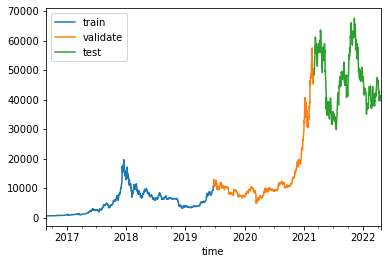

In [22]:
train.close.plot(label='train')
validate.close.plot(label='validate')
test.close.plot(label='test')
plt.legend()

### Differences in split samples:
- Both train and validate include a huge runup, though only train has a large crash afterward
- Test includes a crash from highs in 2021 followed by new all time highs later in the year followed by another crash

### Target exploration:
- primary regression target is forward log returns, which is the difference in close from tomorrow to today
- classification target is whether next close is positive
- returns used (vs absolute prices) so can compare between different time series
- if assume prices are distributed log normally then log 

<AxesSubplot:>

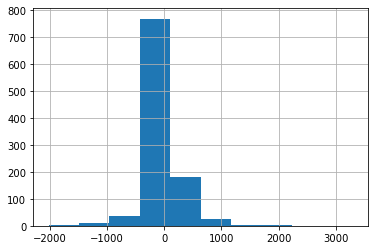

In [23]:
train.fwd_ret.hist()

Text(0.5, 1.0, 'Log returns used because assumed returns follow a log normal distribution\nLog returns are also additive to allow for compounding easily')

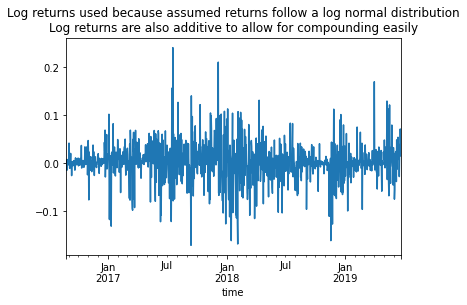

In [24]:
train.fwd_log_ret.plot()
plt.title('Log returns used because assumed returns follow a log normal distribution\nLog returns are also additive to allow for compounding easily')

Text(0.5, 1.0, 'More Normal Looking')

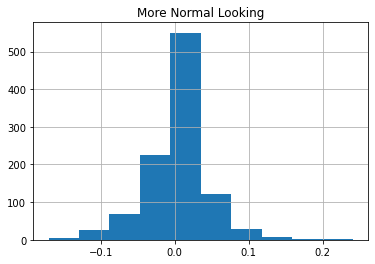

In [25]:
train.fwd_log_ret.hist()
plt.title('More Normal Looking')

<AxesSubplot:xlabel='time'>

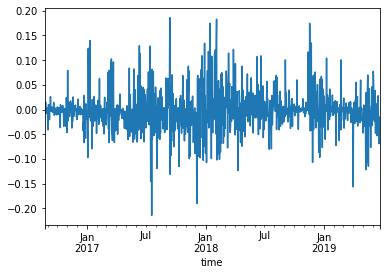

In [26]:
train.fwd_pct_chg.plot()

Text(0.5, 1.0, 'Next Close Positive - fairly balanced')

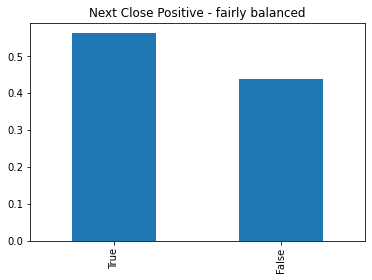

In [27]:
train.fwd_close_positive.value_counts(normalize=True).plot.bar()
plt.title('Next Close Positive - fairly balanced')

### Are there any differences in log returns based on the day of the week or the month of the year?
- Because this is looking at forward log returns it is actually looking at the following day's return

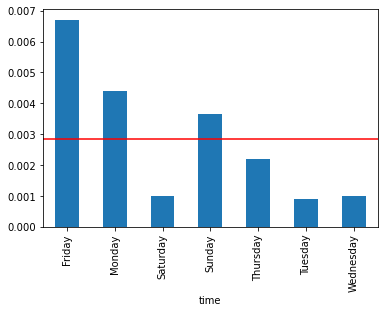

In [28]:
train.groupby(train.index.day_name()).fwd_log_ret.mean().plot.bar()
plt.axhline(train.fwd_log_ret.mean(), color = 'r')

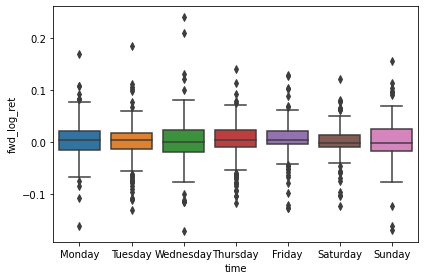

In [29]:
sns.boxplot(x=train.index.day_name(), y = train.fwd_log_ret, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.tight_layout()

In [30]:
# Set alpha to 0.05
alpha = 0.05
overall_mean = train.fwd_log_ret.mean()
for day_of_the_week in train.index.day_name().unique():
    sample = train[train.index.day_name() == day_of_the_week]
    t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
    print(day_of_the_week, t, p<alpha)

Wednesday -0.4382109049371638 False
Thursday -0.19071391435173793 False
Friday 1.2220108640716778 False
Saturday -0.6757647160605057 False
Sunday 0.22803172561984486 False
Monday 0.45829650036842684 False
Tuesday -0.5432212034679261 False


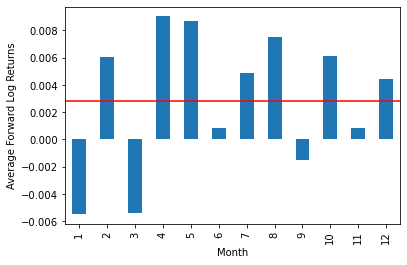

In [31]:
train.groupby(train.index.month).fwd_log_ret.mean().plot.bar()
plt.axhline(train.fwd_log_ret.mean(), color = 'r')
plt.xlabel('Month')
plt.ylabel('Average Forward Log Returns')
None

In [32]:
overall_mean = train.fwd_log_ret.mean()
for month_of_year in train.index.month.unique():
    sample = train[train.index.month == month_of_year]
    t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
    print(month_of_year, t, p<alpha)

8 1.2273269594973495 False
9 -1.1243058735938383 False
10 1.3046282286404267 False
11 -0.4214624142362868 False
12 0.2842678944628774 False
1 -1.636415104926473 False
2 0.6457455426399578 False
3 -2.0085106074230747 True
4 1.6800486284375764 False
5 1.4088257328256801 False
6 -0.4410689548599772 False
7 0.29825054760730546 False


### Takeaways:
- All days exhibit positive log returns for the next day on average
- There is wide variation depending on the day of the week though, suggesting day of the week matters when it comes to predicting returns
- No day's returns are statistically different from the overall mean
- Wednesday and Sunday have the widest spread in values, suggesting Monday and Thursday are some of the more volatile days of the week
- No month except March exhibits average returns significantly different from the overall mean

### Take a look at correlations - not very relevant given time series

In [33]:
# Everything besides encoding day name columns
train[[col for col in train.columns if 'day_name' not in col]].corrwith(train.fwd_log_ret).sort_values(ascending=False)

fwd_log_ret           1.000000
fwd_ret               0.827821
fwd_close_positive    0.667871
log_ret_lag_6         0.049871
sigma_lag_6           0.047553
sigma_lag_2           0.045426
log_ret_lag_5         0.037157
log_ret_lag_7         0.036887
log_ret_lag_3         0.031387
volume                0.031338
log_ret_lag_2         0.020126
RR                    0.018527
sigma_lag_1           0.018403
sigma_lag_7           0.015279
sigma_lag_3           0.012200
log_ret_lag_4         0.005556
log_ret_lag_1        -0.011469
pct_chg              -0.012351
sigma_lag_4          -0.016418
sigma_lag_5          -0.039582
close                -0.065933
high                 -0.066128
low                  -0.066747
open                 -0.068015
fwd_pct_chg          -0.998780
dtype: float64

### Visualize target over time

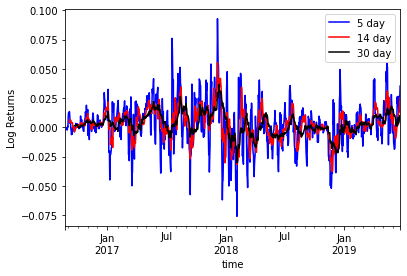

In [34]:
train.fwd_log_ret.rolling(5).mean().plot(label = '5 day',color = 'blue')
train.fwd_log_ret.rolling(14).mean().plot(label = '14 day',color = 'r')
train.fwd_log_ret.rolling(30).mean().plot(label = '30 day',color = 'black')
plt.ylabel('Log Returns')
plt.legend()

### Seasonal plot

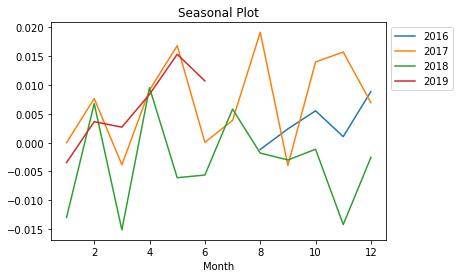

In [35]:
train.fwd_log_ret.groupby([train.index.year, train.index.month]).mean().unstack(0).plot(title='Seasonal Plot')
plt.xlabel("Month")
plt.legend(bbox_to_anchor=(1, 1))

### Takeaways:
- Every March there appears to be a big dip in returns, followed by big bounce up in April
- No other months appear to show seasonality

### Lag plot of log returns

Text(0.5, 1.0, '1 day lag plot of log returns\nNo obvious relationship observed')

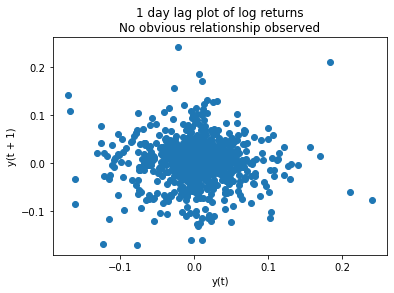

In [36]:
pd.plotting.lag_plot(train.fwd_log_ret, lag = 1)
plt.title('1 day lag plot of log returns\nNo obvious relationship observed')

Text(0.5, 1.0, '1 day lag plot of close price\nDefinitely a linear looking relationship')

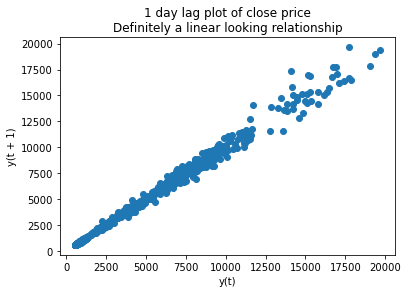

In [37]:
pd.plotting.lag_plot(train.close, lag = 1)
plt.title('1 day lag plot of close price\nDefinitely a linear looking relationship')

### Autocorrelation of daily close - highest correlations with lags < 50

Text(0.5, 1.0, 'No real seasonality evident')

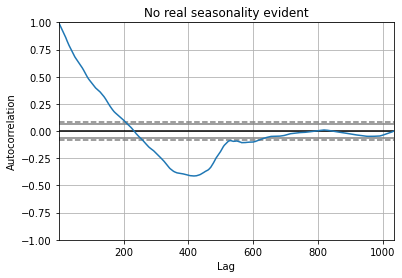

In [38]:
pd.plotting.autocorrelation_plot(train.close)
plt.title('No real seasonality evident')

### Seasonal decomposition

In [39]:
result = sm.tsa.seasonal_decompose(train.fwd_log_ret)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})

<AxesSubplot:xlabel='time'>

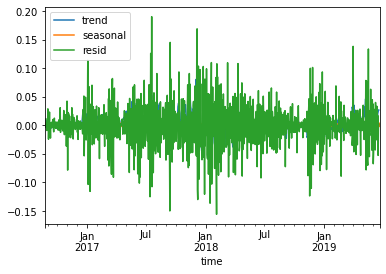

In [40]:
decomposition.iloc[:,1:].plot()

### No seasonality evident

### Plotting some of the predictors vs returns

In [41]:
train.columns

Index(['time', 'low', 'high', 'open', 'close', 'volume', 'fwd_log_ret',
       'fwd_ret', 'fwd_pct_chg', 'fwd_close_positive', 'pct_chg',
       'log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday'],
      dtype='object')

<AxesSubplot:xlabel='RR', ylabel='fwd_log_ret'>

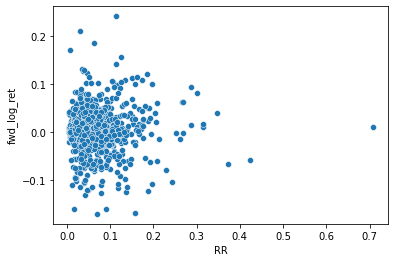

In [463]:
sns.scatterplot(train.RR, train.fwd_log_ret)

# Modeling
- Will start with ARIMA
- After ARIMA will try regression and classification models

### Arima
- Will set up a grid search for best parameters to use
- Based on https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
- No validate dataset needed as ARIMA will perform one day prediction and then will be retrained for next day

In [43]:
def evaluate_arima_model(train, test, target, arima_order):
    """ Evaluates an ARIMA model based on arima_order argument, train set, test set, and target. 
    Outputs error and predictions for every  timestep in test"""
    train_target = train[target]
    test_target = test[target]
    history = [x for x in train_target]

    # Make predictions
    predictions = []
    for t in range(len(test_target)):
        print(f"\tTesting {arima_order} {t}/{len(test_target)}", end="\r")
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        # Forecast returns forecast value, standard error, and confidence interval - only need forecast value ([0])
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # Adds the latest test value to history so it can be used to train
        history.append(test_target[t])
    error = mean_squared_error(test_target, predictions)
    print("\n")
    return error, test_target, predictions

In [44]:
def evaluate_models(train, test, target, p_values, d_values, q_values):
    mses=[]
    prediction_list=[]
    actual_test = []
    orders = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                orders.append(order)
                try:
                    mse, test_target, predictions = evaluate_arima_model(train, test, target, order)
                    mses.append(mse)
                    prediction_list.append(predictions)
                    actual_test.append(test_target)
                except KeyboardInterrupt:
                    print("Keyboard interrupt")
                    raise
                except:
                    print(f"{order} didn't work, continuing with next order")
                    continue
    results_df = pd.DataFrame.from_records(orders, columns = ['p','d','q'])
    results_df["mse"] = mses
    results_df["test_predictions"] = prediction_list
    results_df["test_actual"] = actual_test
    return results_df

In [45]:
# p_values = [1]
# d_values = [3]
# q_values = [3]
# results_df = evaluate_models(train.iloc[:980], train.iloc[980:], 'fwd_log_ret', p_values, d_values, q_values)

In [46]:
# results_df

In [47]:
# real = results_df.test_actual[0]
# predictions = results_df.test_predictions[0]

In [48]:
# plt.figure(figsize=(16,8))
# plt.plot(train.iloc[980:].fwd_log_ret, label = "actual")
# plt.plot(train.iloc[980:].index, predictions, label = "predictions")
# plt.title(f"Actual vs Predictions based on ARIMA 1,3,3: MSE {results_df.mse[0]:.5f}")
# plt.legend()
# plt.tight_layout()

### Best ARIMA parameters based on gridsearch of:
p_values = [0,1,2]
d_values = [0,1,2]
q_values = [0,1,2]
- (p,d,q) = (1,2,2) -> MSE of 0.001813
- 2 is top q and d value
- 1 and 0 top p value

## Evaluate regression models

In [49]:
train.columns

Index(['time', 'low', 'high', 'open', 'close', 'volume', 'fwd_log_ret',
       'fwd_ret', 'fwd_pct_chg', 'fwd_close_positive', 'pct_chg',
       'log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday'],
      dtype='object')

In [72]:
features_to_use = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday']
features_to_scale = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7']


In [73]:
# def evaluate_regression_model(train, validate, test, target, features_to_use, model):



In [74]:
# model = LassoLars()


In [192]:
target = 'fwd_log_ret'
# Segment out features into individual dataframes
X_train = train[features_to_use]
X_validate = validate[features_to_use]
X_test = test[features_to_use]

# Segment out target into individual dataframe
y_train = train[[target]]
y_validate = validate[[target]]
y_test = test[[target]]

# Will scale features using StandardScaler as sigmas are orders of magnitude different from log_ret
scaler = StandardScaler()

# Fit scaler to train. Transform validate and test based on fitted scaler. Concatenate to df with non-scaled features.
X_train_scaled = pd.concat([X_train.drop(columns = features_to_scale),
                            pd.DataFrame(data = scaler.fit_transform(X_train[features_to_scale]), 
                                         columns = features_to_scale, index = X_train.index)], 
                           axis=1)
X_validate_scaled = pd.concat([X_validate.drop(columns = features_to_scale),
                            pd.DataFrame(data = scaler.transform(X_validate[features_to_scale]), 
                                         columns = features_to_scale, index = X_validate.index)], 
                           axis=1)
X_test_scaled = pd.concat([X_test.drop(columns = features_to_scale),
                            pd.DataFrame(data = scaler.transform(X_test[features_to_scale]), 
                                         columns = features_to_scale, index = X_test.index)], 
                           axis=1)

In [84]:
# Feature selection using model (argument)


def get_top_features(X_train_scaled, y_train, model, target, n_features):

    lm = model
    
    rfe = RFE(lm, n_features_to_select= n_features)

    rfe.fit(X_train_scaled, y_train[[target]])

    # Get mask of the columns selected
    feature_mask = rfe.support_

    # Get list of column names
    rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

    # view list of columns and their ranking

    # get the ranks
    var_ranks = rfe.ranking_
    # get the variable names
    var_names = X_train_scaled.columns.tolist()
    # combine ranks and names into a df for clean viewing
    rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
    # sort the df by rank
    rfe_ranks_df.sort_values('Rank')
    
    return rfe_feature


### Evaluate Model on Train and Validate

In [476]:
models = [DecisionTreeRegressor(), KNeighborsRegressor(),  SVR(kernel='linear',gamma=0.1,), LinearRegression(), TweedieRegressor(), LassoLars()]
# RandomForestRegressor(n_estimators=500),

In [477]:
rmses_validate={}
perform_feature_selection = False

for model in models:
    
    regression_model = model
    
    model_name = model.__repr__().split('()')[0]
    
    print(model_name)
    
    if perform_feature_selection:
        
        top_features = get_top_features(X_train_scaled, y_train, model,target, 16)
        
        X_train_scaled_featured = X_train_scaled[top_features]
        X_validate_scaled_featured  = X_validate_scaled[top_features]
        X_test_scaled_featured = X_test_scaled[top_features]
    else:
        X_train_scaled_featured = X_train_scaled
        X_validate_scaled_featured = X_validate_scaled
        X_test_scaled_featured = X_test_scaled
    
    regression_model.fit(X_train_scaled_featured, y_train.fwd_log_ret)

    y_train[model_name] = regression_model.predict(X_train_scaled_featured)

    rmse_train = mean_squared_error(y_train.fwd_log_ret, y_train[model_name], squared=False)

    y_validate[model_name] = regression_model.predict(X_validate_scaled_featured)

    rmse_validate = mean_squared_error(y_validate.fwd_log_ret, y_validate[model_name], squared=False)

    print(f"RMSE for {model_name}\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)
    
    rmses_validate[model_name] = rmse_validate

DecisionTreeRegressor
RMSE for DecisionTreeRegressor
Training/In-Sample:  0.0 
Validation/Out-of-Sample:  0.05408050822740693
KNeighborsRegressor
RMSE for KNeighborsRegressor
Training/In-Sample:  0.03651841344212067 
Validation/Out-of-Sample:  0.045294869653139995
SVR(gamma=0.1, kernel='linear')
RMSE for SVR(gamma=0.1, kernel='linear')
Training/In-Sample:  0.044041103708558835 
Validation/Out-of-Sample:  0.046133946938408665
LinearRegression
RMSE for LinearRegression
Training/In-Sample:  0.04139187282716599 
Validation/Out-of-Sample:  0.043074195015479474
TweedieRegressor
RMSE for TweedieRegressor
Training/In-Sample:  0.04169251976588164 
Validation/Out-of-Sample:  0.042765328851848174
LassoLars
RMSE for LassoLars
Training/In-Sample:  0.04191479329921535 
Validation/Out-of-Sample:  0.04277418289652522


### calculate the average trade return

In [478]:
# Get names of each model
model_names = [m.__repr__().split('()')[0] for m in models]
# Add close prices to y_validate to enable calculated trade return
y_validate["close"] = validate.close
y_validate["next_day_close"] = validate.close.shift(-1)

model_rmse_validate = []
model_average_trade_returns = []

# Iterate through each model
for mod in model_names:
    # Create a column saying whether we would go long or not (short)
    y_validate[mod+"_long"] = y_validate[mod]>0
    # Calculate the return that day (assumes always goes long or short every day)
    y_validate[mod+"_ret"] = np.where(y_validate[mod+"_long"], y_validate.next_day_close-y_validate.close, y_validate.close-y_validate.next_day_close)
    print(mod,round(y_validate[mod+"_ret"].mean(),2))
    model_average_trade_returns.append(y_validate[mod+"_ret"].mean())
    model_rmse_validate.append(rmses_validate[mod])

DecisionTreeRegressor 87.8
KNeighborsRegressor 23.54
SVR(gamma=0.1, kernel='linear') 8.67
LinearRegression 84.36
TweedieRegressor 69.43
LassoLars 63.86


In [479]:
# Add return column to y_validate
y_validate['daily_return'] = validate.fwd_ret

# Create dataframe of avg trade and rmse values
avg_trade_model = pd.DataFrame(data = {'avg_trade':model_average_trade_returns,'rmse':model_rmse_validate}, index = model_names)

# Concatenate to the avg_trade_model df the avg trade we'd get if just bought every day and sold next (close to close)
avg_trade_model= pd.concat([avg_trade_model,pd.DataFrame({'avg_trade':y_validate.daily_return.mean(),'rmse':np.nan}, index = ['buy_everyday'])])

avg_trade_model.sort_values(by='avg_trade',ascending=False)

,avg_trade,rmse
DecisionTreeRegressor,87.803199,0.054081
LinearRegression,84.358998,0.043074
TweedieRegressor,69.428142,0.042765
LassoLars,63.856187,0.042774
buy_everyday,60.541129,NaN
KNeighborsRegressor,23.536640,0.045295
"SVR(gamma=0.1, kernel='linear')",8.673570,0.046134


### Set up rolling train/validate window:
- single step 
- each log return in validate is predicted using a model trained on the preceding 1033 observerations (length of train)
- after making the prediction the first row used for train is removed and the last validate row is added to the train set

In [469]:
def get_rolling_predictions(X_train_scaled_featured, X_validate_scaled_featured, y_train, y_validate, model, target):
                            
    X_train_scaled_featured_rolled = X_train_scaled_featured.copy()
    X_validate_scaled_featured_rolled = X_validate_scaled_featured.copy()
    y_train_rolled = y_train.copy()              
    
    train_rolling_predictions = []
    train_rolling_actuals = []
    validate_rolling_predictions = []
    validate_rolling_actuals = []

    for validate_row in range(len(X_validate_scaled_featured)):

        print(f"{model} {validate_row+1}/{len(X_validate_scaled_featured)} Train X range: {X_train_scaled_featured_rolled.index.min().date()} - {X_train_scaled_featured_rolled.index.max().date()}",end="\r")
        # print(f"\nTrain X range: {X_train_scaled_featured_rolled.index.min().date()} - {X_train_scaled_featured_rolled.index.max().date()}",end="\r")

        # Fit the model to the training data
        # print(f"Fitting to train, X: {X_train_scaled_featured_rolled.index.min().date()} - {X_train_scaled_featured_rolled.index.max().date()}, y: {y_train_rolled.index.min().date()} - {y_train_rolled.index.max().date()}") 
        model.fit(X_train_scaled_featured_rolled, y_train_rolled[target])

        # Predict on Train
        train_prediction = model.predict(X_train_scaled_featured_rolled)
        train_actual = y_train_rolled[target]

        # Append train results to list
        # print(f"First train prediction {train_prediction[0]} vs actual {train_actual[0]}")
        train_rolling_predictions.append(train_prediction)
        train_rolling_actuals.append(train_actual)

        # Predict on validate
        validate_rolling_predictions.append(model.predict(X_validate_scaled_featured_rolled.iloc[validate_row].array.reshape(1,-1)))
        validate_rolling_actuals.append(y_validate.iloc[validate_row][target])

        # Remove the first row from X train and y train
        X_train_scaled_featured_rolled = X_train_scaled_featured_rolled.iloc[1:]
        y_train_rolled= y_train_rolled.iloc[1:]

        # Add the latest row from X validate and y validate
        X_train_scaled_featured_rolled = X_train_scaled_featured_rolled.append(X_validate_scaled_featured.iloc[validate_row])
        y_train_rolled = y_train_rolled.append(y_validate.iloc[validate_row])
    
    return train_rolling_predictions, train_rolling_actuals, validate_rolling_predictions, validate_rolling_actuals


In [471]:
model_results = {}

for model in models:
    
    model_name = model.__repr__().split('()')[0]
    
    train_rolling_predictions, train_rolling_actuals, validate_rolling_predictions, validate_rolling_actuals = get_rolling_predictions(X_train_scaled_featured, X_validate_scaled_featured, y_train, y_validate, model, 'fwd_log_ret')
    
    # Calculate validate RMSE
    validate_rmse = mean_squared_error(validate_rolling_actuals, [v[0] for v in validate_rolling_predictions], squared=False)
    
    print(model_name,"avg validate rmse",validate_rmse)
    
    # Create a dataframe with actual validate log returns, predictions, close prices, next day close prices
    validate_res = pd.DataFrame()
    validate_res['actual'] = validate_rolling_actuals
    # validate_res = validate_res.T
    # validate_res = validate_res.rename(columns = {'fwd_log_ret':'actual'})

    validate_res['predictions'] = [v[0] for v in validate_rolling_predictions]
    
    validate_res.index = validate.index
    
    validate_res["close"] = validate.close
    validate_res["next_day_close"] = validate.close.shift(-1)
    # Create a column saying whether we would go long or not (short) based on the 
    validate_res["go_long"] = validate_res['predictions']>0
    # Calculate the return that day (assumes always goes long or short every day)
    validate_res["ret"] = np.where(validate_res["go_long"], validate_res.next_day_close-validate_res.close, validate_res.close-validate_res.next_day_close)

    model_results[model_name] = validate_res


LinearRegression avg validate rmse 0.0434349044883176262021-03-02
DecisionTreeRegressor avg validate rmse 0.06131868865352343 2021-03-02


In [472]:
for key in model_results.keys():
    print(key, "Avg Trade", round(model_results[key].ret.mean(),2))

LinearRegression Avg Trade 44.24
DecisionTreeRegressor Avg Trade 12.34


In [508]:
class_models = [LogisticRegression(C=10), DecisionTreeClassifier(max_depth=None), RandomForestClassifier(n_estimators=500), KNeighborsClassifier(n_neighbors=10), KNeighborsClassifier(n_neighbors=100), KNeighborsClassifier(n_neighbors=1000)]
model_results = {}

y_train = train[['fwd_close_positive']]
y_validate = validate[['fwd_close_positive']]

for model in class_models:
    
    model_name = model.__repr__().split('()')[0]
    
    train_rolling_predictions, train_rolling_actuals, validate_rolling_predictions, validate_rolling_actuals = get_rolling_predictions(X_train_scaled_featured, X_validate_scaled_featured, y_train, y_validate, model, 'fwd_close_positive')
    
    # Calculate validate accuracy
    validate_accuracy = accuracy_score(validate_rolling_actuals, [v[0] for v in validate_rolling_predictions])
    
    print(model_name,"validate accuracy",validate_accuracy)
    
    # Create a dataframe with actual validate log returns, predictions, close prices, next day close prices
    validate_res = pd.DataFrame()
    validate_res['actual'] = validate_rolling_actuals
    # validate_res = validate_res.T
    # validate_res = validate_res.rename(columns = {'fwd_log_ret':'actual'})

    validate_res['predictions'] = [v[0] for v in validate_rolling_predictions]
    
    validate_res.index = validate.index
    
    validate_res["close"] = validate.close
    validate_res["next_day_close"] = validate.close.shift(-1)
    # Create a column saying whether we would go long or not (short) based on the 
    validate_res["go_long"] = validate_res['predictions']>0
    # Calculate the return that day (assumes always goes long or short every day)
    validate_res["ret"] = np.where(validate_res["go_long"], validate_res.next_day_close-validate_res.close, validate_res.close-validate_res.next_day_close)

    model_results[model_name] = validate_res
    model_results[model_name+"_accuracy"] = validate_accuracy

baseline = pd.DataFrame(index = validate.index)
baseline["close"] = validate.close
baseline["next_day_close"] = validate.close.shift(-1)
# Just predict most common value
baseline["predictions"] = train.fwd_close_positive.mode()[0]
# Where prediction is true, go long
baseline["go_long"] = baseline["predictions"]
# Calculate the return that day (assumes always goes long or short every day)
baseline["ret"] = np.where(baseline["go_long"], baseline.next_day_close-baseline.close, baseline.close-baseline.next_day_close)

model_results["baseline"] = baseline



LogisticRegression(C=10) validate accuracy 0.50483870967741942021-03-02
DecisionTreeClassifier validate accuracy 0.4935483870967742- 2021-03-02


KeyboardInterrupt: 

In [506]:
for key in model_results.keys():
    print(key, "Avg Trade", round(model_results[key].ret.mean(),2))

LogisticRegression(C=10) Avg Trade -2.83
LogisticRegression Avg Trade -2.83
DecisionTreeClassifier(max_depth=4) Avg Trade 16.97
RandomForestClassifier Avg Trade 47.91
KNeighborsClassifier(n_neighbors=10) Avg Trade 38.37
KNeighborsClassifier(n_neighbors=100) Avg Trade 42.63
baseline Avg Trade 63.86
